# Alternatives to differential abundance analysis for OOR state detection

In this notebook we test the ability to detect OOR states without using differential abundance analysis, testing 3 alternatives:

1. Distance/segregation of OOR cells in latent space
2. Query-mapping quality control metrics
3. Differential expression analysis after label transfer

### Preparations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import oor_benchmark
import oor_benchmark.metrics.utils

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_v2/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R -i figdir
library(tidyverse)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [9]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

In [10]:
short_pop_names = {
    "DC":'conventional_dendritic_cell', 
    "naive B":'naive_B_cell',
    "memory B":'memory_B_cell',
    "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell', 
    'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
     "neutrophil":'neutrophil',
#     "cDC":'conventional_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
    'CD14+ monocyte':'CD14_positive_monocyte',
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte',
    "HPP":'hematopoietic_precursor_cell'
}

short_pop_names={v:k for k,v in short_pop_names.items()}

## 1. Distance/segregation of OOR cells in latent space

Here we want to test whether position in the latent space can always distinguish the OOR state. We train a KNN classifier to distinguish the OOR state in simulations with one removed OOR state (using results from ) 

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def classify_OOR(adata, n_iters = 5, split_seed=42):
    '''Train classifier on latent space to identify OOR cell state in disease cells'''
    X = adata[adata.obs['dataset_group'] == 'query'].obsm['X_scVI'].copy()
    y = adata[adata.obs['dataset_group'] == 'query'].obs['OOR_state']
    class_out = {'precision':[], 'recall':[], 'f1-score':[], 'accuracy':[], 'support':[]}
    for s in np.arange(split_seed, split_seed+n_iters):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=s)

#         clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        clf = KNeighborsClassifier(n_neighbors=50, metric="euclidean").fit(X_train, y_train)
        class_out_iter = classification_report(y_test, clf.predict(X_test), output_dict=True)['1']
        class_out_iter['accuracy'] = classification_report(y_test, clf.predict(X_test), output_dict=True)['accuracy']
        for k in class_out.keys():
            class_out[k].append(class_out_iter[k])
    return(pd.DataFrame(class_out))

In [19]:
classifier_outs_all = pd.DataFrame()
for ct in [k for k,v in oor_state_size.items() if v > 100]: ## Select simulations with at least 100 cells in OOR state 
    d = f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'
    print(d)
    acr_adata = milopy.utils.read_milo_adata(outdir + d + '/ACR_design.scArches_milo.h5ad', backed=True)
    ar_adata = milopy.utils.read_milo_adata(outdir + d + '/ar_design.h5ad', backed=True)
    cr_adata = milopy.utils.read_milo_adata(outdir + d + '/CR_design.scArches_milo.h5ad', backed=True)
    cr_scvi_adata = milopy.utils.read_milo_adata(outdir + d + '/CR_design.scVI_milo.h5ad', backed=True)
    AR_classifier_outs = classify_OOR(ar_adata, split_seed=312, n_iters=10)
    AR_classifier_outs['design'] = 'AR'
    CR_classifier_outs = classify_OOR(cr_adata, split_seed=312, n_iters=10)
    CR_classifier_outs['design'] = 'CR scArches'
    CR_scVI_classifier_outs = classify_OOR(cr_scvi_adata, split_seed=312, n_iters=10)
    CR_scVI_classifier_outs['design'] = 'CR scVI'
    ACR_classifier_outs = classify_OOR(acr_adata, split_seed=312, n_iters=10)
    ACR_classifier_outs['design'] = 'ACR'
    classifier_outs = pd.concat([ACR_classifier_outs, AR_classifier_outs, CR_classifier_outs, CR_scVI_classifier_outs])
    classifier_outs['OOR_state_name'] = ct
    classifier_outs_all = pd.concat([classifier_outs_all, classifier_outs])

qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_per

In [20]:
classifier_outs_all

,precision,recall,f1-score,accuracy,support,design,OOR_state_name
0,0.854962,0.829630,0.842105,0.983044,135,ACR,memory_B_cell
1,0.880597,0.825175,0.851986,0.983448,143,ACR,memory_B_cell
2,0.814570,0.848276,0.831081,0.979814,145,ACR,memory_B_cell
3,0.834532,0.794521,0.814035,0.978603,146,ACR,memory_B_cell
4,0.805970,0.857143,0.830769,0.982237,126,ACR,memory_B_cell
...,...,...,...,...,...,...,...
5,0.897436,0.972222,0.933333,0.997981,36,CR scVI,CD14_low_CD16_positive_monocyte
6,0.936170,0.936170,0.936170,0.997578,47,CR scVI,CD14_low_CD16_positive_monocyte
7,0.938776,0.978723,0.958333,0.998385,47,CR scVI,CD14_low_CD16_positive_monocyte
8,0.953488,0.976190,0.964706,0.998789,42,CR scVI,CD14_low_CD16_positive_monocyte


In [52]:
# plt.rcParams['figure.figsize'] = [6,10]
# sorted_cts = classifier_outs_all[classifier_outs_all.design == 'ACR'].groupby('OOR_state_name').first()['support'].sort_values().index

# sns.boxplot(data = classifier_outs_all, y = 'OOR_state_name', x = 'precision', hue = 'design', orient = 'h', order=sorted_cts, width=0.5);
# plt.show()
# sns.boxplot(data = classifier_outs_all, y = 'OOR_state_name', x = 'accuracy', hue = 'design', orient = 'h', order=sorted_cts, width=0.5)

In [21]:
classifier_outs_all['OOR_state_name'] = [short_pop_names[x] for x in classifier_outs_all.OOR_state_name]

In [22]:
%%R -i classifier_outs_all
head(classifier_outs_all)

  precision    recall  f1-score  accuracy support design OOR_state_name
1 0.8549618 0.8296296 0.8421053 0.9830440     135    ACR       memory B
2 0.8805970 0.8251748 0.8519856 0.9834477     143    ACR       memory B
3 0.8145695 0.8482759 0.8310811 0.9798143     145    ACR       memory B
4 0.8345324 0.7945205 0.8140351 0.9786031     146    ACR       memory B
5 0.8059701 0.8571429 0.8307692 0.9822366     126    ACR       memory B
6 0.8031496 0.8095238 0.8063241 0.9802180     126    ACR       memory B


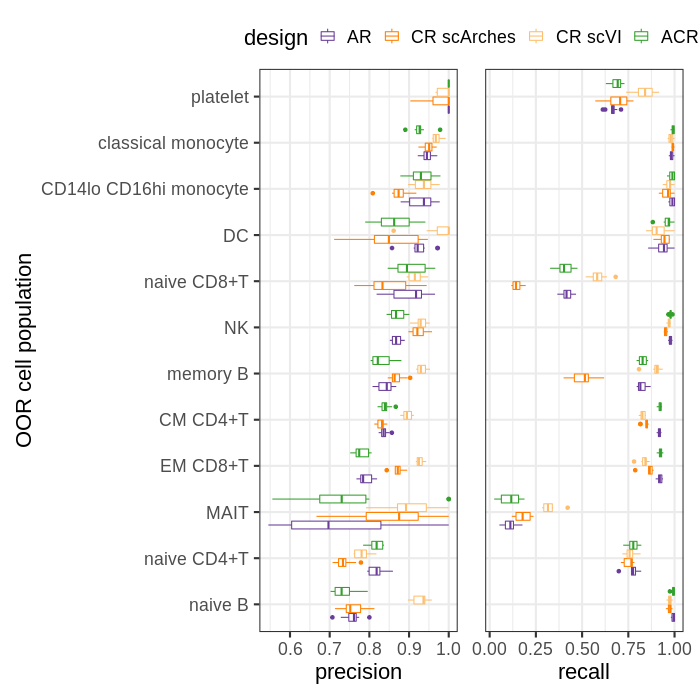

In [24]:
%%R -w 700 -h 700
pl_df <- classifier_outs_all %>%
    group_by(OOR_state_name) %>%
    mutate(mean_precision = median(precision), mean_accuracy = median(accuracy)) %>%
    ungroup() %>%
    arrange(mean_precision) %>%
    mutate(OOR_state_name = factor(OOR_state_name, levels=unique(OOR_state_name))) %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", 'CR scVI', "ACR"))) 
    
p1 <- pl_df %>%
    ggplot(aes(OOR_state_name, precision, color=design)) +
    geom_boxplot() +
    scale_color_manual(values=design_palette) +
    coord_flip() +
    theme_bw(base_size=22) +
    xlab('OOR cell population') +
    theme(legend.position='top')

p2 <- pl_df %>%
    ggplot(aes(OOR_state_name, `recall`, color=design)) +
    geom_boxplot() +
    scale_color_manual(values=design_palette) +
    coord_flip() +
    theme_bw(base_size=22) +
    theme(legend.position='top')
    
(p1 + (p2 + remove_y_axis()) + plot_layout(guides='collect') & theme(legend.position='top')) +
ggsave(paste0(figdir, 'OOR_state_classifier_precision_recall.png'), width=12, height=7) +
ggsave(paste0(figdir, 'OOR_state_classifier_precision_recall.pdf'), width=12, height=7)